In [1]:

%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pytorch_experiment
plt.rcParams['image.cmap'] = 'gray'


In [7]:
from torchsummary import summary
import torch
use_cuda=torch.cuda.is_available()


import os
import datasets
import pytorch_models
import torch.optim as optim
dataset_name="mnist"
(x_train, y_train), (x_test, y_test), input_shape,num_classes = datasets.get_data(dataset_name)
dataset=pytorch_experiment.ClassificationDataset(dataset_name,x_train,x_test,y_train,y_test,num_classes,input_shape)

print('x_train shape:', x_train.shape,x_train.dtype)
print('x_test shape:', x_test.shape,x_test.dtype)
print('y_train shape:', y_train.shape,y_train.dtype)
print('y_test shape:', y_test.shape,y_test.dtype)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


import numpy as np
print(np.unique(y_train.argmax(axis=1)))
print(y_train.min(),y_train.max())


x_train shape: (60000, 28, 28, 1) uint8
x_test shape: (10000, 28, 28, 1) uint8
y_train shape: (60000, 10) float64
y_test shape: (10000, 10) float64
60000 train samples
10000 test samples
[0 1 2 3 4 5 6 7 8 9]
0.0 1.0


In [10]:
filters={"mnist":16,"mnist_rot":16,"cifar10":96}
def subset(l,indices):
    return [l[i] for i in indices]

def freeze_layers_except(layers,layer_names,layers_to_train):
    for i in range(len(layers)):
        name=layer_names[i]
        layer=layers[i]
        requires_grad=name in layers_to_train
        #print(f"Layer {name}: setting requires_grad to {requires_grad}.")
        for param in layer.parameters():
            param.requires_grad=requires_grad


            
def model_optimizer_generator(previous_model=None,trainable_layers=None):
    model = pytorch_models.AllConv(dataset.input_shape,dataset.num_classes,
                                     filters=filters[dataset.name])
    if use_cuda:
        model=model.cuda()
    if previous_model:
        model.load_state_dict(previous_model.state_dict())
        
    if trainable_layers:
        freeze_layers_except(model.layers(),model.layer_names(),trainable_layers)
        
    parameters=pytorch_experiment.add_weight_decay(model.named_parameters(),1e-9)
    optimizer = optim.Adam(parameters, lr=0.001)
    
    return model,optimizer

model,optimizer=model_optimizer_generator()
print(model)



AllConv(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvBNAct(
      (model): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (4): ConvBNAct(
      (model): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (5): ConvBNAct(
      (model): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (6): ConvBNAct(
      (mode

In [13]:



epochs={'cifar10':10,'mnist':5,'fashion_mnist':12,'cluttered_mnist':10,'lsa16':15,'mnist_rot':5,'pugeault':15}

rotated_epochs={'cifar10':80,'mnist':5,'fashion_mnist':60,'cluttered_mnist':30,'lsa16':100,'mnist_rot':5,'pugeault':40}

layer_names=model.layer_names()
loss_function=torch.nn.NLLLoss()
batch_size=256
initial_epochs=7
retrain_epochs=10
conv_layer_names= list(filter(lambda name: name.startswith("conv"),layer_names))
retrained_layers_schemes=  [[l] for l in layer_names]  + [conv_layer_names] + [layer_names]
labels = ["none"] + layer_names+["all_conv","all"]


print("Retraining schemes:\n")
print("\n".join(map(lambda scheme: "_".join(scheme),retrained_layers_schemes)))

config=pytorch_experiment.RetrainConfig(batch_size,initial_epochs,retrain_epochs,use_cuda,loss_function)
scores,models,unrotated_accuracies,rotated_accuracies=pytorch_experiment.retraining(model_optimizer_generator,retrained_layers_schemes,config,dataset)






Retraining schemes:

conv0
conv1
conv2
conv3
conv4
conv5
conv6
conv7
class_conv
conv0_conv1_conv2_conv3_conv4_conv5_conv6_conv7
conv0_conv1_conv2_conv3_conv4_conv5_conv6_conv7_class_conv


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Training vanilla network with unrotated dataset..


Epoch 1: 100% (batch 235/235)  ==stats==> loss:   1.37, accuracy:  0.666, Time:  0:00:05


Test => Loss: 0.5791, Accuracy: 87.63% (8763/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:   1.65, accuracy:  0.499, Time:  0:00:05


Test => Loss: 0.6198, Accuracy: 83.28% (8328/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:  0.276, accuracy:  0.923, Time:  0:00:05


Test => Loss: 0.1646, Accuracy: 95.51% (9551/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:  0.137, accuracy:   0.96, Time:  0:00:05


Test => Loss: 0.1154, Accuracy: 96.66% (9666/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:  0.101, accuracy:  0.971, Time:  0:00:05


Test => Loss: 0.0777, Accuracy: 97.73% (9773/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss: 0.0811, accuracy:  0.977, Time:  0:00:05


Test => Loss: 0.0800, Accuracy: 97.44% (9744/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss: 0.0663, accuracy:  0.981, Time:  0:00:05


Test => Loss: 0.0595, Accuracy: 98.28% (9828/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv0'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:    1.8, accuracy:  0.415, Time:  0:00:06


Test => Loss: 1.5450, Accuracy: 49.71% (4971/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:   1.35, accuracy:  0.534, Time:  0:00:06


Test => Loss: 1.2394, Accuracy: 56.88% (5688/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:   1.19, accuracy:  0.587, Time:  0:00:06


Test => Loss: 1.1285, Accuracy: 61.11% (6111/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:   1.11, accuracy:  0.616, Time:  0:00:06


Test => Loss: 1.0588, Accuracy: 62.98% (6298/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:   1.06, accuracy:  0.631, Time:  0:00:06


Test => Loss: 1.0236, Accuracy: 64.46% (6446/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:   1.03, accuracy:  0.643, Time:  0:00:06


Test => Loss: 0.9908, Accuracy: 65.32% (6532/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.995, accuracy:  0.654, Time:  0:00:06


Test => Loss: 0.9704, Accuracy: 66.36% (6636/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:  0.981, accuracy:  0.661, Time:  0:00:06


Test => Loss: 0.9371, Accuracy: 67.34% (6734/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:  0.958, accuracy:  0.671, Time:  0:00:06


Test => Loss: 0.9312, Accuracy: 67.83% (6783/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.942, accuracy:  0.677, Time:  0:00:06


Test => Loss: 0.9095, Accuracy: 68.45% (6845/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv1'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:   1.71, accuracy:  0.455, Time:  0:00:06


Test => Loss: 1.4222, Accuracy: 54.13% (5413/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:   1.24, accuracy:  0.575, Time:  0:00:06


Test => Loss: 1.2345, Accuracy: 56.68% (5668/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:   1.08, accuracy:  0.629, Time:  0:00:06


Test => Loss: 1.0324, Accuracy: 64.22% (6422/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:  0.999, accuracy:   0.66, Time:  0:00:06


Test => Loss: 0.9422, Accuracy: 66.92% (6692/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:  0.942, accuracy:   0.68, Time:  0:00:06


Test => Loss: 0.9431, Accuracy: 67.13% (6713/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:  0.914, accuracy:  0.687, Time:  0:00:06


Test => Loss: 0.8577, Accuracy: 70.69% (7069/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.886, accuracy:    0.7, Time:  0:00:06


Test => Loss: 0.8652, Accuracy: 70.54% (7054/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:   0.86, accuracy:  0.707, Time:  0:00:06


Test => Loss: 0.8259, Accuracy: 71.66% (7166/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:   0.83, accuracy:  0.721, Time:  0:00:06


Test => Loss: 0.8006, Accuracy: 73.11% (7311/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.813, accuracy:  0.729, Time:  0:00:06


Test => Loss: 0.7808, Accuracy: 74.21% (7421/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv2'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:   1.65, accuracy:  0.479, Time:  0:00:06


Test => Loss: 1.2986, Accuracy: 58.63% (5863/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:   1.16, accuracy:  0.606, Time:  0:00:06


Test => Loss: 1.0553, Accuracy: 62.93% (6293/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:  0.998, accuracy:  0.662, Time:  0:00:06


Test => Loss: 0.9362, Accuracy: 69.05% (6905/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:  0.935, accuracy:  0.686, Time:  0:00:06


Test => Loss: 0.8954, Accuracy: 69.49% (6949/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:  0.889, accuracy:  0.702, Time:  0:00:06


Test => Loss: 0.8254, Accuracy: 72.08% (7208/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:  0.848, accuracy:  0.719, Time:  0:00:06


Test => Loss: 0.8379, Accuracy: 71.97% (7197/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.822, accuracy:  0.729, Time:  0:00:06


Test => Loss: 0.7824, Accuracy: 74.20% (7420/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:  0.796, accuracy:  0.738, Time:  0:00:06


Test => Loss: 0.7649, Accuracy: 74.77% (7477/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:  0.782, accuracy:  0.746, Time:  0:00:06


Test => Loss: 0.7851, Accuracy: 74.00% (7400/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.761, accuracy:  0.751, Time:  0:00:06


Test => Loss: 0.7349, Accuracy: 75.36% (7536/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv3'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:   1.49, accuracy:  0.545, Time:  0:00:06


Test => Loss: 1.1235, Accuracy: 65.87% (6587/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:  0.906, accuracy:  0.707, Time:  0:00:06


Test => Loss: 0.8013, Accuracy: 72.50% (7250/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:  0.725, accuracy:  0.769, Time:  0:00:06


Test => Loss: 0.6364, Accuracy: 79.53% (7953/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:  0.653, accuracy:  0.792, Time:  0:00:06


Test => Loss: 0.5910, Accuracy: 81.91% (8191/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:  0.611, accuracy:  0.805, Time:  0:00:06


Test => Loss: 0.5657, Accuracy: 81.23% (8123/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:  0.577, accuracy:  0.816, Time:  0:00:06


Test => Loss: 0.5443, Accuracy: 82.34% (8234/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.548, accuracy:  0.825, Time:  0:00:06


Test => Loss: 0.4900, Accuracy: 84.68% (8468/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:  0.532, accuracy:   0.83, Time:  0:00:06


Test => Loss: 0.4946, Accuracy: 84.41% (8441/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:  0.515, accuracy:  0.834, Time:  0:00:06


Test => Loss: 0.5030, Accuracy: 84.57% (8457/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.497, accuracy:  0.842, Time:  0:00:06


Test => Loss: 0.5040, Accuracy: 83.50% (8350/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv4'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:   1.34, accuracy:  0.611, Time:  0:00:06


Test => Loss: 0.8723, Accuracy: 76.67% (7667/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:   0.75, accuracy:  0.764, Time:  0:00:06


Test => Loss: 0.5809, Accuracy: 82.18% (8218/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:  0.558, accuracy:  0.826, Time:  0:00:06


Test => Loss: 0.5552, Accuracy: 81.92% (8192/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:  0.506, accuracy:  0.842, Time:  0:00:06


Test => Loss: 0.4685, Accuracy: 85.26% (8526/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:  0.475, accuracy:   0.85, Time:  0:00:06


Test => Loss: 0.4275, Accuracy: 86.55% (8655/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:  0.448, accuracy:  0.857, Time:  0:00:06


Test => Loss: 0.3938, Accuracy: 87.65% (8765/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.421, accuracy:  0.867, Time:  0:00:06


Test => Loss: 0.4009, Accuracy: 86.85% (8685/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:  0.408, accuracy:   0.87, Time:  0:00:06


Test => Loss: 0.5221, Accuracy: 83.07% (8307/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:  0.401, accuracy:  0.872, Time:  0:00:06


Test => Loss: 0.3699, Accuracy: 88.12% (8812/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:   0.39, accuracy:  0.876, Time:  0:00:06


Test => Loss: 0.3580, Accuracy: 88.72% (8872/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv5'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:   1.37, accuracy:    0.6, Time:  0:00:06


Test => Loss: 0.9363, Accuracy: 74.46% (7446/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:  0.706, accuracy:  0.778, Time:  0:00:06


Test => Loss: 0.5954, Accuracy: 81.16% (8116/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:  0.563, accuracy:  0.823, Time:  0:00:06


Test => Loss: 0.5101, Accuracy: 84.65% (8465/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:  0.512, accuracy:   0.84, Time:  0:00:06


Test => Loss: 0.4653, Accuracy: 84.85% (8485/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:  0.486, accuracy:  0.848, Time:  0:00:06


Test => Loss: 0.4600, Accuracy: 84.85% (8485/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:  0.454, accuracy:  0.858, Time:  0:00:06


Test => Loss: 0.4179, Accuracy: 87.05% (8705/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.435, accuracy:  0.864, Time:  0:00:06


Test => Loss: 0.4198, Accuracy: 86.45% (8645/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:   0.43, accuracy:  0.864, Time:  0:00:06


Test => Loss: 0.3764, Accuracy: 88.01% (8801/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:  0.416, accuracy:  0.869, Time:  0:00:06


Test => Loss: 0.3860, Accuracy: 87.54% (8754/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.397, accuracy:  0.875, Time:  0:00:06


Test => Loss: 0.3713, Accuracy: 88.04% (8804/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv6'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:   1.46, accuracy:  0.563, Time:  0:00:06


Test => Loss: 1.0419, Accuracy: 72.34% (7234/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:  0.775, accuracy:  0.754, Time:  0:00:06


Test => Loss: 0.6578, Accuracy: 78.40% (7840/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:  0.615, accuracy:  0.808, Time:  0:00:06


Test => Loss: 0.5360, Accuracy: 83.46% (8346/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:  0.551, accuracy:  0.827, Time:  0:00:06


Test => Loss: 0.4862, Accuracy: 84.55% (8455/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:  0.501, accuracy:  0.843, Time:  0:00:06


Test => Loss: 0.4789, Accuracy: 84.23% (8423/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:  0.455, accuracy:  0.858, Time:  0:00:06


Test => Loss: 0.4062, Accuracy: 87.17% (8717/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.435, accuracy:  0.864, Time:  0:00:06


Test => Loss: 0.4015, Accuracy: 87.14% (8714/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:  0.417, accuracy:   0.87, Time:  0:00:06


Test => Loss: 0.3884, Accuracy: 88.12% (8812/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:   0.39, accuracy:  0.878, Time:  0:00:06


Test => Loss: 0.3602, Accuracy: 88.66% (8866/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.385, accuracy:   0.88, Time:  0:00:06


Test => Loss: 0.3414, Accuracy: 89.52% (8952/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv7'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:   1.72, accuracy:  0.442, Time:  0:00:06


Test => Loss: 1.4181, Accuracy: 55.66% (5566/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:   1.18, accuracy:  0.601, Time:  0:00:06


Test => Loss: 1.0525, Accuracy: 63.97% (6397/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:   1.02, accuracy:  0.657, Time:  0:00:06


Test => Loss: 0.9585, Accuracy: 67.95% (6795/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:  0.951, accuracy:  0.683, Time:  0:00:06


Test => Loss: 0.9137, Accuracy: 70.05% (7005/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:  0.891, accuracy:  0.706, Time:  0:00:06


Test => Loss: 0.8475, Accuracy: 71.67% (7167/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:  0.849, accuracy:  0.723, Time:  0:00:06


Test => Loss: 0.8082, Accuracy: 73.02% (7302/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.812, accuracy:  0.734, Time:  0:00:06


Test => Loss: 0.7780, Accuracy: 74.53% (7453/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:  0.787, accuracy:  0.741, Time:  0:00:06


Test => Loss: 0.7422, Accuracy: 75.33% (7533/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:  0.769, accuracy:  0.747, Time:  0:00:06


Test => Loss: 0.7464, Accuracy: 74.88% (7488/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.744, accuracy:  0.755, Time:  0:00:06


Test => Loss: 0.7175, Accuracy: 76.49% (7649/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['class_conv'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:   1.81, accuracy:  0.412, Time:  0:00:06


Test => Loss: 1.5820, Accuracy: 47.69% (4769/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:   1.38, accuracy:  0.523, Time:  0:00:06


Test => Loss: 1.2682, Accuracy: 56.14% (5614/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:   1.22, accuracy:  0.574, Time:  0:00:06


Test => Loss: 1.1566, Accuracy: 60.05% (6005/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:   1.15, accuracy:  0.599, Time:  0:00:06


Test => Loss: 1.1050, Accuracy: 60.63% (6063/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:    1.1, accuracy:  0.615, Time:  0:00:06


Test => Loss: 1.0616, Accuracy: 62.81% (6281/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:   1.07, accuracy:  0.627, Time:  0:00:06


Test => Loss: 1.0432, Accuracy: 63.26% (6326/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:   1.04, accuracy:  0.636, Time:  0:00:06


Test => Loss: 1.0110, Accuracy: 64.91% (6491/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:   1.02, accuracy:  0.647, Time:  0:00:06


Test => Loss: 0.9859, Accuracy: 65.47% (6547/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:      1, accuracy:  0.656, Time:  0:00:07


Test => Loss: 0.9721, Accuracy: 66.28% (6628/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.982, accuracy:  0.664, Time:  0:00:06


Test => Loss: 0.9357, Accuracy: 67.76% (6776/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:  0.919, accuracy:  0.766, Time:  0:00:07


Test => Loss: 0.4613, Accuracy: 89.72% (8972/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:   1.94, accuracy:  0.383, Time:  0:00:08


Test => Loss: 1.1799, Accuracy: 57.52% (5752/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:  0.899, accuracy:  0.705, Time:  0:00:08


Test => Loss: 0.5341, Accuracy: 83.64% (8364/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:  0.475, accuracy:  0.855, Time:  0:00:08


Test => Loss: 0.3558, Accuracy: 88.90% (8890/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:  0.363, accuracy:  0.889, Time:  0:00:08


Test => Loss: 0.3053, Accuracy: 90.16% (9016/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:  0.315, accuracy:  0.902, Time:  0:00:08


Test => Loss: 0.2879, Accuracy: 90.47% (9047/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.284, accuracy:  0.912, Time:  0:00:08


Test => Loss: 0.2398, Accuracy: 92.49% (9249/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:  0.256, accuracy:  0.921, Time:  0:00:08


Test => Loss: 0.2045, Accuracy: 93.52% (9352/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:  0.244, accuracy:  0.925, Time:  0:00:08


Test => Loss: 0.2277, Accuracy: 92.98% (9298/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.228, accuracy:  0.929, Time:  0:00:08


Test => Loss: 0.2207, Accuracy: 92.53% (9253/10000)


Epoch 1: N/A% (batch 0/235)  ==stats==> loss: ------, accuracy: ------, ETA:  --:--:--

Retraining ['conv0', 'conv1', 'conv2', 'conv3', 'conv4', 'conv5', 'conv6', 'conv7', 'class_conv'] with rotated dataset:


Epoch 1: 100% (batch 235/235)  ==stats==> loss:  0.927, accuracy:  0.763, Time:  0:00:07


Test => Loss: 0.4878, Accuracy: 88.66% (8866/10000)


Epoch 2: 100% (batch 235/235)  ==stats==> loss:    2.4, accuracy:  0.153, Time:  0:00:08


Test => Loss: 2.0666, Accuracy: 25.13% (2513/10000)


Epoch 3: 100% (batch 235/235)  ==stats==> loss:   1.88, accuracy:  0.308, Time:  0:00:08


Test => Loss: 1.5665, Accuracy: 44.35% (4435/10000)


Epoch 4: 100% (batch 235/235)  ==stats==> loss:   1.43, accuracy:  0.491, Time:  0:00:08


Test => Loss: 1.1539, Accuracy: 59.93% (5993/10000)


Epoch 5: 100% (batch 235/235)  ==stats==> loss:   1.08, accuracy:  0.632, Time:  0:00:07


Test => Loss: 0.8857, Accuracy: 70.21% (7021/10000)


Epoch 6: 100% (batch 235/235)  ==stats==> loss:  0.791, accuracy:  0.744, Time:  0:00:07


Test => Loss: 0.7555, Accuracy: 73.41% (7341/10000)


Epoch 7: 100% (batch 235/235)  ==stats==> loss:  0.624, accuracy:  0.807, Time:  0:00:08


Test => Loss: 0.4973, Accuracy: 84.97% (8497/10000)


Epoch 8: 100% (batch 235/235)  ==stats==> loss:  0.506, accuracy:  0.849, Time:  0:00:08


Test => Loss: 0.4016, Accuracy: 88.10% (8810/10000)


Epoch 9: 100% (batch 235/235)  ==stats==> loss:  0.432, accuracy:  0.872, Time:  0:00:08


Test => Loss: 0.3487, Accuracy: 89.16% (8916/10000)


Epoch 10: 100% (batch 235/235)  ==stats==> loss:  0.371, accuracy:  0.888, Time:  0:00:08


Test => Loss: 0.3188, Accuracy: 89.90% (8990/10000)
Evaluating accuracy for all models/datasets:


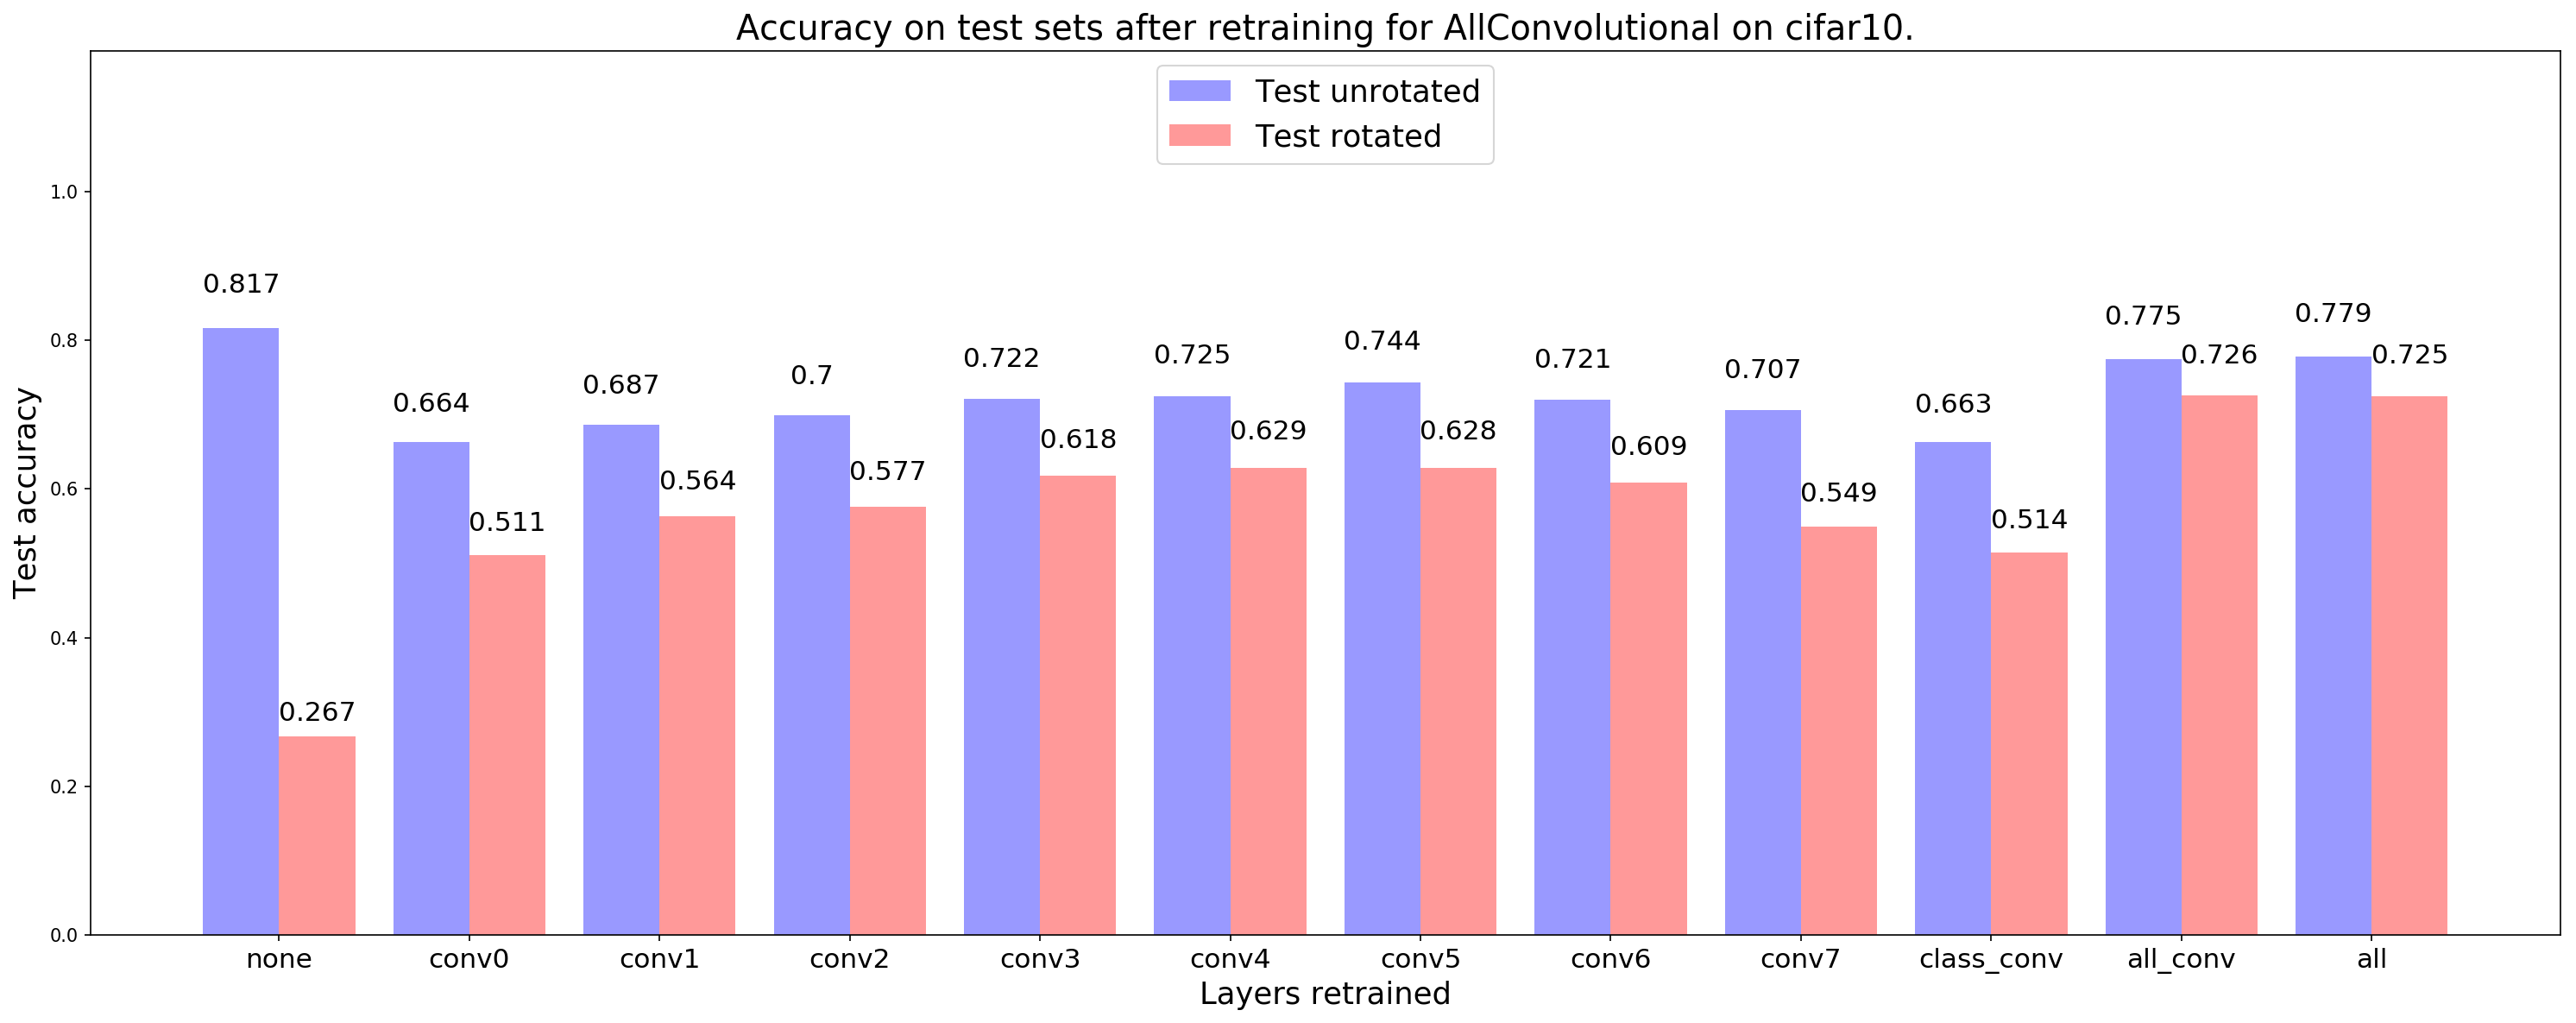

'plots/retraining_AllConvolutional_cifar10.png'

In [5]:

pytorch_experiment.retraining_accuracy_barchart(model.name,dataset.name,unrotated_accuracies,rotated_accuracies,labels,savefig=True)

In [6]:
from datetime import datetime

output_file="results/retraining_allconv.txt"
general_message="%s\nResults on dataset %s with model %s\n" % (str(datetime.now()),dataset.name,model.name,)

pytorch_experiment.write_scores(scores,output_file,general_message)


2018-09-11 01:44:51.900494
Results on dataset cifar10 with model AllConvolutional

None_rotated_test_dataset score: loss=7.307536, accuracy=0.265800

None_rotated_train_dataset score: loss=7.167547, accuracy=0.276340

None_test_dataset score: loss=0.927448, accuracy=0.816700

None_train_dataset score: loss=0.058947, accuracy=0.980860

retrained_class_conv_rotated_test_dataset score: loss=1.344956, accuracy=0.512100

retrained_class_conv_rotated_train_dataset score: loss=1.332201, accuracy=0.519420

retrained_class_conv_test_dataset score: loss=0.939932, accuracy=0.663000

retrained_class_conv_train_dataset score: loss=0.866670, accuracy=0.694620

retrained_conv0_rotated_test_dataset score: loss=1.338806, accuracy=0.522100

retrained_conv0_rotated_train_dataset score: loss=1.313706, accuracy=0.525640

retrained_conv0_test_dataset score: loss=0.942119, accuracy=0.663800

retrained_conv0_train_dataset score: loss=0.863921, accuracy=0.695460

retrained_conv0_conv1_conv2_conv3_conv4_conv5_c

#### 